<a href="https://colab.research.google.com/github/addaia/TechnicalProject/blob/main/ML_GSM8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**4 Supervised non LLMs**

In [7]:
#!pip install datasets scienceplots only if necessary

In [5]:
# imports
import os
import re
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display
import scienceplots
plt.style.use('science')

# parameters for the science style -- too many
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    "font.size": 22,
    "axes.labelsize": 22,
    "legend.fontsize": 22,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "legend.fancybox": True,
    "legend.frameon": True,
    "legend.edgecolor": "black",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "#b7b7b7",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
})

,Model,Parameters,Accuracy,TimeTaken,Precision,Recall,F1-score
12,LogisticRegression,"{'C': 1, 'max_iter': 500, 'solver': 'lbfgs'}",0.029613,42.333256,0.001295,0.003517,0.001527
74,RandomForest,"{'n_estimators': 100, 'max_depth': 5, 'min_sam...",0.034169,1.053289,0.000914,0.003844,0.001201
186,SVM,"{'C': 1, 'kernel': 'linear', 'gamma': 'scale'}",0.030372,68.587183,0.001585,0.003679,0.001818


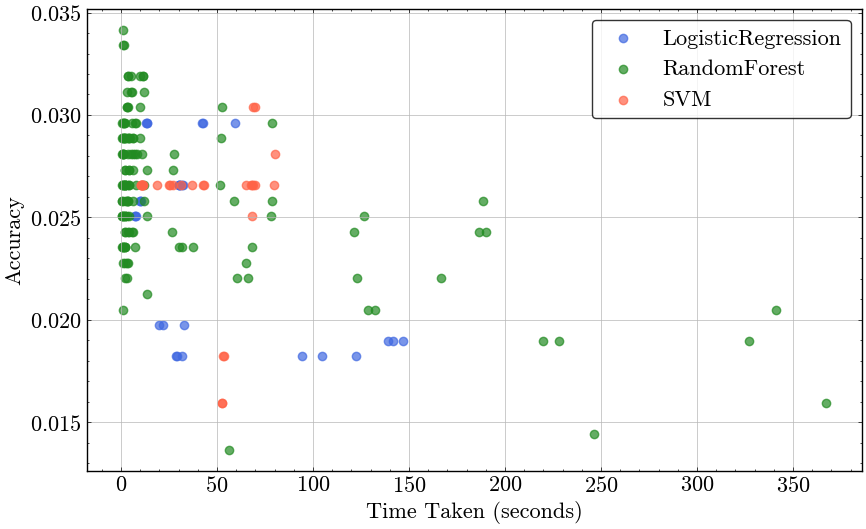

In [ ]:
# define models and parameters to 'fine tune'
models = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [500, 1000, 2000],
        'solver': ['lbfgs', 'liblinear']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'SVM': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    }
}

# preprocess dataset:
#   question -- same
#   answer ---- number (only)
def preprocess_gsm8k(dataset):
    preprocessed_data = []
    for example in dataset:
        question = example["question"]
        answer = example["answer"]
        extracted_answer = re.findall(r"####\s*(\d+)", answer)
        if extracted_answer:
            formatted_answer = extracted_answer[-1]
            preprocessed_data.append({"question": question, "answer": formatted_answer})
    return preprocessed_data

# preprocess dataset -- vectorise inputs to be able to enter algortihms
def load_and_vectorize_data():
    dataset = load_dataset("gsm8k", "main")
    train_data = preprocess_gsm8k(dataset['train'])
    test_data = preprocess_gsm8k(dataset.get('test', dataset.get('validation')))

    train_df = pd.DataFrame(train_data)
    test_df = pd.DataFrame(test_data)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
    X_train = vectorizer.fit_transform(train_df['question'])
    X_test = vectorizer.transform(test_df['question'])

    y_train = train_df['answer'].astype(int)
    y_test = test_df['answer'].astype(int)

    return X_train, X_test, y_train, y_test, vectorizer

# train and evaluate
def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, params):
    if model_name == 'LogisticRegression':
        model = LogisticRegression(**params)
    elif model_name == 'RandomForest':
        model = RandomForestClassifier(**params)
    elif model_name == 'SVM':
        model = SVC(**params)

    # calculate time taken
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time

    # record aaccuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)

    return accuracy, report, elapsed_time

# hyperparameter Sweep
X_train, X_test, y_train, y_test, vectorizer = load_and_vectorize_data()

results = []
if X_train is not None:
    for model_name, param_grid in models.items():
        keys, values = zip(*param_grid.items())
        for combination in itertools.product(*values):
            params = dict(zip(keys, combination))
            accuracy, report, elapsed_time = train_and_evaluate(X_train, X_test, y_train, y_test, model_name, params)
            results.append({
                'Model': model_name,
                'Parameters': params,
                'Accuracy': accuracy,
                'TimeTaken': elapsed_time,
                'Precision': report['macro avg']['precision'],
                'Recall': report['macro avg']['recall'],
                'F1-score': report['macro avg']['f1-score']
            })

# to df
results_df = pd.DataFrame(results)

# disp best params per model
best_results = results_df.loc[results_df.groupby('Model')['Accuracy'].idxmax()]
display(best_results)

# save if wanted
# results_df.to_csv('hyperparameter_sweep_results.csv', index=False)



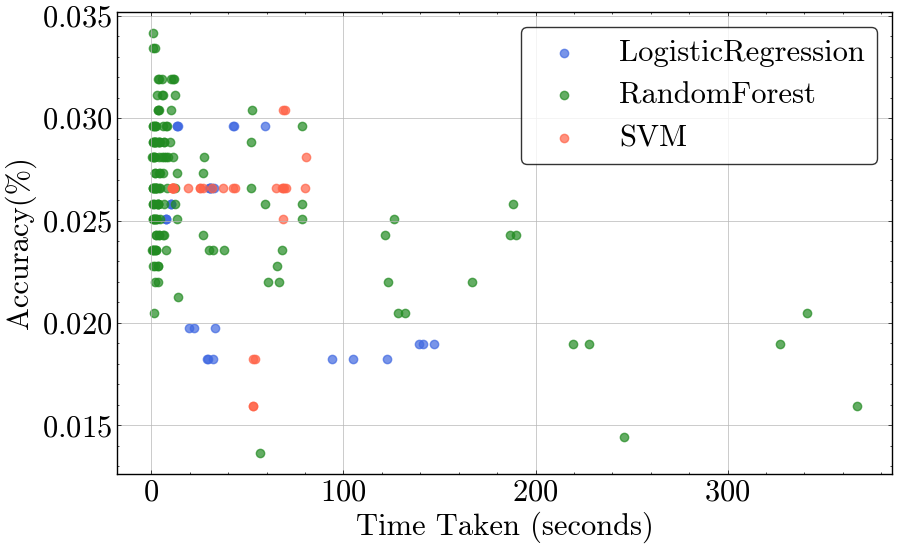

In [9]:
# plot
plt.figure(figsize=(10, 6))
colors = {'LogisticRegression': 'royalblue', 'RandomForest': 'forestgreen', 'SVM': 'tomato'}

for model_name in models.keys():
    subset = results_df[results_df['Model'] == model_name]
    plt.scatter(subset['TimeTaken'], subset['Accuracy'], label=model_name, color=colors[model_name], alpha=0.7)

plt.xlabel('Time Taken (seconds)')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.grid(True)

#download
plt.savefig('hyperparameter_sweep_results.pdf', dpi=300, bbox_inches='tight')
plt.show()